In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

# Large Scale Text Classification for Sentiment Analysis

## Scalability Issues

The `sklearn.feature_extraction.text.CountVectorizer` and `sklearn.feature_extraction.text.TfidfVectorizer` classes suffer from a number of scalability issues that all stem from the internal usage of the `vocabulary_` attribute (a Python dictionary) used to map the unicode string feature names to the integer feature indices.

The main scalability issues are:

- **Memory usage of the text vectorizer**: the all the string representations of the features are loaded in memory
- **Parallelization problems for text feature extraction**: the `vocabulary_` would be a shared state: complex synchronization and overhead
- **Impossibility to do online or out-of-core / streaming learning**: the `vocabulary_` needs to be learned from the data: its size cannot be known before making one pass over the full dataset
    
    
To better understand the issue let's have a look at how the `vocabulary_` attribute work. At `fit` time the tokens of the corpus are uniquely indentified by a integer index and this mapping stored in the vocabulary:

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)

vectorizer.fit([
    "The cat sat on the mat.",
])
vectorizer.vocabulary_

{'cat': 0, 'mat': 1, 'on': 2, 'sat': 3, 'the': 4}

The vocabulary is used at `transform` time to build the occurrence matrix:

In [3]:
X = vectorizer.transform([
    "The cat sat on the mat.",
    "This cat is a nice cat.",
]).toarray()

print(len(vectorizer.vocabulary_))
print(vectorizer.get_feature_names())
print(X)

5
['cat', 'mat', 'on', 'sat', 'the']
[[1 1 1 1 2]
 [2 0 0 0 0]]


Let's refit with a slightly larger corpus:

In [4]:
vectorizer = CountVectorizer(min_df=1)

vectorizer.fit([
    "The cat sat on the mat.",
    "The quick brown fox jumps over the lazy dog.",
])
vectorizer.vocabulary_

{'brown': 0,
 'cat': 1,
 'dog': 2,
 'fox': 3,
 'jumps': 4,
 'lazy': 5,
 'mat': 6,
 'on': 7,
 'over': 8,
 'quick': 9,
 'sat': 10,
 'the': 11}

The `vocabulary_` is the (logarithmically) growing with the size of the training corpus. Note that we could not have built the vocabularies in parallel on the 2 text documents as they share some words hence would require some kind of shared datastructure or synchronization barrier which is complicated to setup, especially if we want to distribute the processing on a cluster.

With this new vocabulary, the dimensionality of the output space is now larger:

In [5]:
X = vectorizer.transform([
    "The cat sat on the mat.",
    "This cat is a nice cat.",
]).toarray()

print(len(vectorizer.vocabulary_))
print(vectorizer.get_feature_names())
print(X)

12
['brown', 'cat', 'dog', 'fox', 'jumps', 'lazy', 'mat', 'on', 'over', 'quick', 'sat', 'the']
[[0 1 0 0 0 0 1 1 0 0 1 2]
 [0 2 0 0 0 0 0 0 0 0 0 0]]


## The Sentiment 140 Dataset

To illustrate the scalability issues of the vocabulary-based vectorizers, let's load a more realistic dataset for a classical text classification task: sentiment analysis on tweets. The goal is to tell apart negative from positive tweets on a variety of topics.

Assuming that the `../fetch_data.py` script was run successfully the following files should be available:

In [6]:
import os

sentiment140_folder = os.path.join('datasets', 'sentiment140')
training_csv_file = os.path.join(sentiment140_folder, 'training.1600000.processed.noemoticon.csv')
testing_csv_file = os.path.join(sentiment140_folder, 'testdata.manual.2009.06.14.csv')

Those files were downloaded from the research archive of the http://www.sentiment140.com/ project. The first file was gathered using the twitter streaming API by running stream queries for the positive ":)" and negative ":(" emoticons to collect tweets that are explicitly positive or negative. To make the classification problem non-trivial, the emoticons were stripped out of the text in the CSV files.

Let's parse the CSV files and load everything in memory. As loading everything can take up to 2GB, let's limit the collection to 100K tweets of each (positive and negative) out of the total of 1.6M tweets.

In [8]:
from helpers import read_sentiment_csv
%time text_train_all, target_train_all = read_sentiment_csv(training_csv_file, max_count=200000)

CPU times: user 21.7 s, sys: 276 ms, total: 22 s
Wall time: 22.1 s


In [9]:
len(text_train_all), len(target_train_all)

(200000, 200000)

Let's display the first samples:

In [10]:
for text in text_train_all[:3]:
    print(text + "\n")

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds



In [11]:
print(target_train_all[:3])

[-1, -1, -1]


A polarity of "-1" means negative while a polarity of "1" means positive. All the positive tweets are at the end of the file:

In [12]:
for text in text_train_all[-3:]:
    print(text + "\n")

Okie doke!! Time for me to escape for the North while Massa's back is turned. Be on when I get home folks 

finished the lessons, hooray! 

Some ppl are just fucking KP0. Cb ! Stop asking me laa.. I love my boyfriend and thats it. 



In [13]:
print(target_train_all[-3:])

[1, 1, 1]


Let's split the training CSV file into a smaller training set and a validation set with 100k random tweets each:

In [14]:
from sklearn.cross_validation import train_test_split

text_train_small, text_validation, target_train_small, target_validation = train_test_split(
    text_train_all, np.array(target_train_all), test_size=.5, random_state=42)

In [15]:
len(text_train_small)

100000

In [16]:
(target_train_small == -1).sum(), (target_train_small == 1).sum()

(50143, 49857)

In [17]:
len(text_validation)

100000

In [18]:
(target_validation == -1).sum(), (target_validation == 1).sum()

(49857, 50143)

Let's open the manually annotated tweet files. The evaluation set also has neutral tweets with a polarity of "2" which we ignore. We can build the final evaluation set with only the positive and negative tweets of the evaluation CSV file:

In [19]:
text_test_all, target_test_all = read_sentiment_csv(testing_csv_file)

In [20]:
len(text_test_all), len(target_test_all)

(359, 359)

## The Hashing Trick

Remember the bag of word representation using a vocabulary based vectorizer:

<img src="images/bag_of_words.svg" width="80%">

To workaround the limitations of the vocabulary-based vectorizers, one can use the hashing trick. Instead of building and storing an explicit mapping from the feature names to the feature indices in a Python dict, we can just use a hash function and a modulus operation:

<img src="images/hashing_vectorizer.svg" width="80%">

In [21]:
from sklearn.utils.murmurhash import murmurhash3_bytes_u32

# encode for python 3 compatibility
for word in "the cat sat on the mat".encode("utf-8").split():
    print("{0} => {1}".format(
        word, murmurhash3_bytes_u32(word, 0) % 2 ** 20))

b'the' => 761698
b'cat' => 300839
b'sat' => 122804
b'on' => 735689
b'the' => 761698
b'mat' => 122997


This mapping is completely stateless and the dimensionality of the output space is explicitly fixed in advance (here we use a modulo `2 ** 20` which means roughly 1M dimensions). The makes it possible to workaround the limitations of the vocabulary based vectorizer both for parallelizability and online / out-of-core learning.

The `HashingVectorizer` class is an alternative to the `TfidfVectorizer` class with `use_idf=False` that internally uses the murmurhash hash function:

In [22]:
from sklearn.feature_extraction.text import HashingVectorizer

h_vectorizer = HashingVectorizer(encoding='latin-1')
h_vectorizer

HashingVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='latin-1',
         input='content', lowercase=True, n_features=1048576,
         ngram_range=(1, 1), non_negative=False, norm='l2',
         preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)

It shares the same "preprocessor", "tokenizer" and "analyzer" infrastructure:

In [23]:
analyzer = h_vectorizer.build_analyzer()
analyzer('This is a test sentence.')

['this', 'is', 'test', 'sentence']

We can vectorize our datasets into a scipy sparse matrix exactly as we would have done with the `CountVectorizer` or `TfidfVectorizer`, except that we can directly call the `transform` method: there is no need to `fit` as `HashingVectorizer` is a stateless transformer:

In [24]:
%time X_train_small = h_vectorizer.transform(text_train_small)

CPU times: user 2.83 s, sys: 32 ms, total: 2.86 s
Wall time: 2.87 s


The dimension of the output is fixed ahead of time to `n_features=2 ** 20` by default (nearly 1M features) to minimize the rate of collision on most classification problem while having reasonably sized linear models (1M weights in the `coef_` attribute):

In [25]:
X_train_small

<100000x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 1188916 stored elements in Compressed Sparse Row format>

As only the non-zero elements are stored, `n_features` has little impact on the actual size of the data in memory. We can combine the hashing vectorizer with a Passive-Aggressive linear model in a pipeline:

In [26]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline

h_pipeline = Pipeline((
    ('vec', HashingVectorizer(encoding='latin-1')),
    ('clf', PassiveAggressiveClassifier(C=1, n_iter=1)),
))

%time h_pipeline.fit(text_train_small, target_train_small).score(text_validation, target_validation)

CPU times: user 6.11 s, sys: 77.4 ms, total: 6.18 s
Wall time: 5.81 s


0.75048999999999999

Let's check that the score on the validation set is reasonably in line with the set of manually annotated tweets:

In [27]:
h_pipeline.score(text_test_all, target_test_all)

0.74373259052924789

As the `text_train_small` dataset is not that big we can still use a vocabulary based vectorizer to check that the hashing collisions are not causing any significant performance drop on the validation set (**WARNING** this is twice as slow as the hashing vectorizer version, skip this cell if your computer is too slow):

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_vec = TfidfVectorizer(encoding='latin-1', use_idf=False)
vocabulary_pipeline = Pipeline((
    ('vec', vocabulary_vec),
    ('clf', PassiveAggressiveClassifier(C=1, n_iter=1)),
))

%time vocabulary_pipeline.fit(text_train_small, target_train_small).score(text_validation, target_validation)

CPU times: user 5.36 s, sys: 171 ms, total: 5.53 s
Wall time: 5.13 s


0.74736999999999998

We get almost the same score but almost twice as slower with also a big, slow to (un)pickle datastructure in memory:

In [29]:
len(vocabulary_vec.vocabulary_)

91301

More info and reference for the original papers on the Hashing Trick in the [following site ](http://www.hunch.net/~jl/projects/hash_reps/index.html) as well as a description specific to language [here](http://blog.someben.com/2013/01/hashing-lang/).

## Out-of-Core learning

Out-of-Core learning is the task of training a machine learning model on a dataset that does not fit in the main memory. This requires the following conditions:
    
- a **feature extraction** layer with **fixed output dimensionality**
- knowing the list of all classes in advance (in this case we only have positive and negative tweets)
- a machine learning **algorithm that supports incremental learning** (the `partial_fit` method in scikit-learn).

Let us simulate an infinite tweeter stream that can generate batches of annotated tweet texts and there polarity. We can do this by recombining randomly pairs of positive or negative tweets from our fixed dataset:

In [30]:
from random import Random


class InfiniteStreamGenerator(object):
    """Simulate random polarity queries on the twitter streaming API"""
    
    def __init__(self, texts, targets, seed=0, batchsize=100):
        self.texts_pos = [text for text, target in zip(texts, targets)
                               if target > 0]
        self.texts_neg = [text for text, target in zip(texts, targets)
                               if target <= 0]
        self.rng = Random(seed)
        self.batchsize = batchsize

    def next_batch(self, batchsize=None):
        batchsize = self.batchsize if batchsize is None else batchsize
        texts, targets = [], []
        for i in range(batchsize):
            # Select the polarity randomly
            target = self.rng.choice((-1, 1))
            targets.append(target)
            
            # Combine 2 random texts of the right polarity
            pool = self.texts_pos if target > 0 else self.texts_neg
            text = self.rng.choice(pool) + " " + self.rng.choice(pool)
            texts.append(text)
        return texts, targets

infinite_stream = InfiniteStreamGenerator(text_train_small, target_train_small)

In [31]:
texts_in_batch, targets_in_batch = infinite_stream.next_batch(batchsize=3)

In [32]:
for t in texts_in_batch:
    print(t + "\n")

@policymonk I read the funnies first. Puts the day in perspective  @theitalianjob: mac sux (= 

@dizzyfeet I just saw an old clip of you on Idol and it made me miss having you there.  @louisgray there is a Tweetie for desktop Mac? What about PC? 

@AKGovSarahPalin Welcome to Twitter Governor Palin  Great to be able to get updates on Alaska, all the way from NY! We love and miss you! zack shelton, yes i will be sasha for you 



In [33]:
targets_in_batch

[1, -1, 1]

We can now use our infinte tweet source to train an online machine learning algorithm using the hashing vectorizer. Note the use of the `partial_fit` method of the `PassiveAggressiveClassifier` instance in place of the traditional call to the `fit` method that needs access to the full training set.

From time to time, we evaluate the current predictive performance of the model on our validation set that is guaranteed to not overlap with the infinite training set source:

In [34]:
n_batches = 1000
validation_scores = []
training_set_size = []

# Build the vectorizer and the classifier
h_vectorizer = HashingVectorizer(encoding='latin-1')
clf = PassiveAggressiveClassifier(C=1)

# Extract the features for the validation once and for all
X_validation = h_vectorizer.transform(text_validation)
classes = np.array([-1, 1])

n_samples = 0
for i in range(n_batches):
    
    texts_in_batch, targets_in_batch = infinite_stream.next_batch()    
    n_samples += len(texts_in_batch)

    # Vectorize the text documents in the batch
    X_batch = h_vectorizer.transform(texts_in_batch)
    
    # Incrementally train the model on the new batch
    clf.partial_fit(X_batch, targets_in_batch, classes=classes)
    
    if n_samples % 100 == 0:
        # Compute the validation score of the current state of the model
        score = clf.score(X_validation, target_validation)
        validation_scores.append(score)
        training_set_size.append(n_samples)

    if i % 100 == 0:
        print("n_samples: {0}, score: {1:.4f}".format(n_samples, score))

n_samples: 100, score: 0.5880
n_samples: 10100, score: 0.7351
n_samples: 20100, score: 0.7390
n_samples: 30100, score: 0.7507
n_samples: 40100, score: 0.7583
n_samples: 50100, score: 0.7580
n_samples: 60100, score: 0.7466
n_samples: 70100, score: 0.7358
n_samples: 80100, score: 0.7484
n_samples: 90100, score: 0.7565


We can now plot the collected validation score values, versus the number of samples generated by the infinite source and feed to the model:

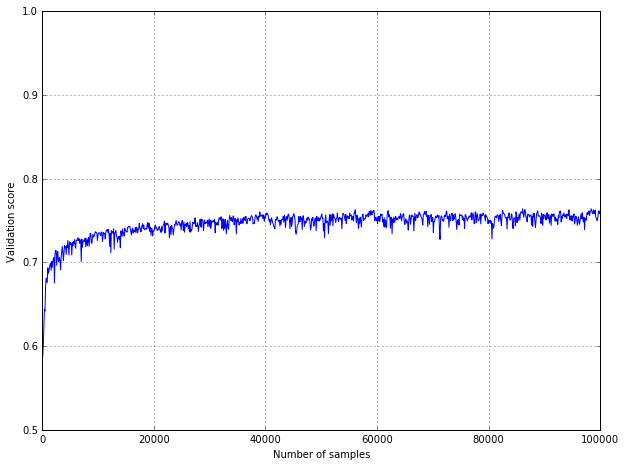

In [35]:
plt.plot(training_set_size, validation_scores)
plt.ylim(0.5, 1)
plt.xlabel("Number of samples")
plt.ylabel("Validation score")

### Limitations of the Hashing Vectorizer

Using the Hashing Vectorizer makes it possible to implement streaming and parallel text classification but can also introduce some issues:
    
- The collisions can introduce too much noise in the data and degrade prediction quality,
- The `HashingVectorizer` does not provide "Inverse Document Frequency" reweighting (lack of a `use_idf=True` option).
- There is no easy way to inverse the mapping and find the feature names from the feature index.

The collision issues can be controlled by increasing the `n_features` parameters.

The IDF weighting might be reintroduced by appending a `TfidfTransformer` instance on the output of the vectorizer. However computing the `idf_` statistic used for the feature reweighting will require to do at least one additional pass over the training set before being able to start training the classifier: this breaks the online learning scheme.

The lack of inverse mapping (the `get_feature_names()` method of `TfidfVectorizer`) is even harder to workaround. That would require extending the `HashingVectorizer` class to add a "trace" mode to record the mapping of the most important features to provide statistical debugging information.

In the mean time to debug feature extraction issues, it is recommended to use `TfidfVectorizer(use_idf=False)` on a small-ish subset of the dataset to simulate a `HashingVectorizer()` instance that have the `get_feature_names()` method and no collision issues.